#Analyzing Educational Inequality Across U.S. Schools.

This project explores the question: How do socioeconomic factors relate to average student performance on the ACT or SAT exams across U.S. schools?

In this analysis, we use two datasets, one from [**EdGap.org**](https://www.edgap.org/#5/37.892/-95.977) and another from the [**National Center for Education Statistics (NCES)**](https://nces.ed.gov/ccd/pubschuniv.asp).

The [**EdGap_data.xlsx**](https://github.com/brian-fischer/DATA-5100/blob/main/EdGap_data.xlsx) file includes 2016 data on school's average ACT/SAT scores and several socioeconomic variables such as household income, unemployment rate, adult education level, and family structure.  
The [**ccd_sch_029_1617_w_1a_11212017.csv**](https://www.dropbox.com/s/lkl5nvcdmwyoban/ccd_sch_029_1617_w_1a_11212017.csv?dl=1) dataset provides school level details like name, type, level, and location.

We will:
- Explore, clean, and merge the datasets  
- Handle missing or inconsistent values  
- Visualize relationships between socioeconomic indicators and ACT/SAT performance  
- Identify which factors show the strongest association with student performance  

By the end of this project, we will understand how economic and social conditions influence educational outcomes across different school communities in the United States.


###Importing necessary libraires

In [ ]:
# Import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# seaborn
import seaborn as sns
# set the plotting style
sns.set_style("whitegrid")

# Model preprocessing
from sklearn.preprocessing import StandardScaler

# Modeling
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Model metrics and analysis
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.anova import anova_lm

#Iterative Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


print ('Imported!')

Imported!


###We will start by loading the educational datasets.

1. Edgap Data

In [ ]:
# Load the EdGap dataset
edgap = pd.read_excel(
    "https://raw.githubusercontent.com/anushkanaidu/Education-Project-/main/Education/Data/EdGap_data.xlsx",
    dtype={'NCESSCH School ID': object}
)

/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning:

Unknown extension is not supported and will be removed



2. School Info Data

In [ ]:
#downloading the School Information dataset
!curl -L -o ccd_sch_029_1617_w_1a_11212017.csv \
  "https://dl.dropboxusercontent.com/scl/fi/fhterkw1ndhtvj7nb5hg7/ccd_sch_029_1617_w_1a_11212017-1.csv?rlkey=0qg40lfx6nrq532qszyfdoq8z&st=ceeh9e7o&dl=1"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 38.6M  100 38.6M    0     0  53.1M      0 --:--:-- --:--:-- --:--:-- 53.0M


Let us now read the data into Python.

In [ ]:
school_information = pd.read_csv("ccd_sch_029_1617_w_1a_11212017.csv", encoding="unicode_escape")


/tmp/ipython-input-1947944053.py:1: DtypeWarning:

Columns (6,9,14,15,18,19,21,22,25,26,29,31,35,39,41,42) have mixed types. Specify dtype option on import or set low_memory=False.



###Exploring both the Datasets
As a part of data exploration, I used the info( ) method to check dataset’s shape, columns, data types, and missing values.

*(I removed some of the code cells used for this inspection to keep the notebook cleaner, but these steps were performed to ensure the data was complete, consistent, and ready for analysis.)*

### Data Preparation
As part of data preparation, we will rename the columns in the EdGap dataset and the school info data set to follow best practices and improve readability.  
We will select only the relevant columns needed for this analysis to keep the data clean and focused on key variables.

In [ ]:
#renaming the columns
edgap = edgap.rename(columns={
    "NCESSCH School ID": "id",
    "CT Pct Adults with College Degree": "percent_college",
    "CT Unemployment Rate": "rate_unemployment",
    "CT Pct Childre In Married Couple Family": "percent_married",
    "CT Median Household Income": "median_income",
    "School ACT average (or equivalent if SAT score)": "average_act",
    "School Pct Free and Reduced Lunch": "percent_lunch"
})

school_information = school_information.rename(columns={
    "SCHOOL_YEAR": "year",
    "NCESSCH": "id",
    "LSTATE": "state",
    "LZIP": "zip_code",
    "SCH_TYPE_TEXT": "school_type",
    "LEVEL": "school_level",
    "CHARTER_TEXT": "charter"
})

print('renamed!')

renamed!


In [ ]:
#selecting only relevant columns using the new column names
school_information = school_information[
    ['year', 'id', 'state', 'zip_code', 'school_type', 'school_level', 'charter']
]

### Pre-Data Visualization

Before performing deeper analysis, we go through some plots to check the usability of the datasets and see if they are even meaningful.   

Step 1: look at a pair plot and make observations.
step 2: add regression lines to the same plot to observe some more patterns and relationships.

1. **Performing a Pair Plot**

To quickly assess whether there is a relationship between the ACT score and the socioeconomic variables, we will be using a pair plot. It helps you quickly understand how variables relate to each other before doing deeper statistical analysis.

<Figure size 800x800 with 0 Axes>

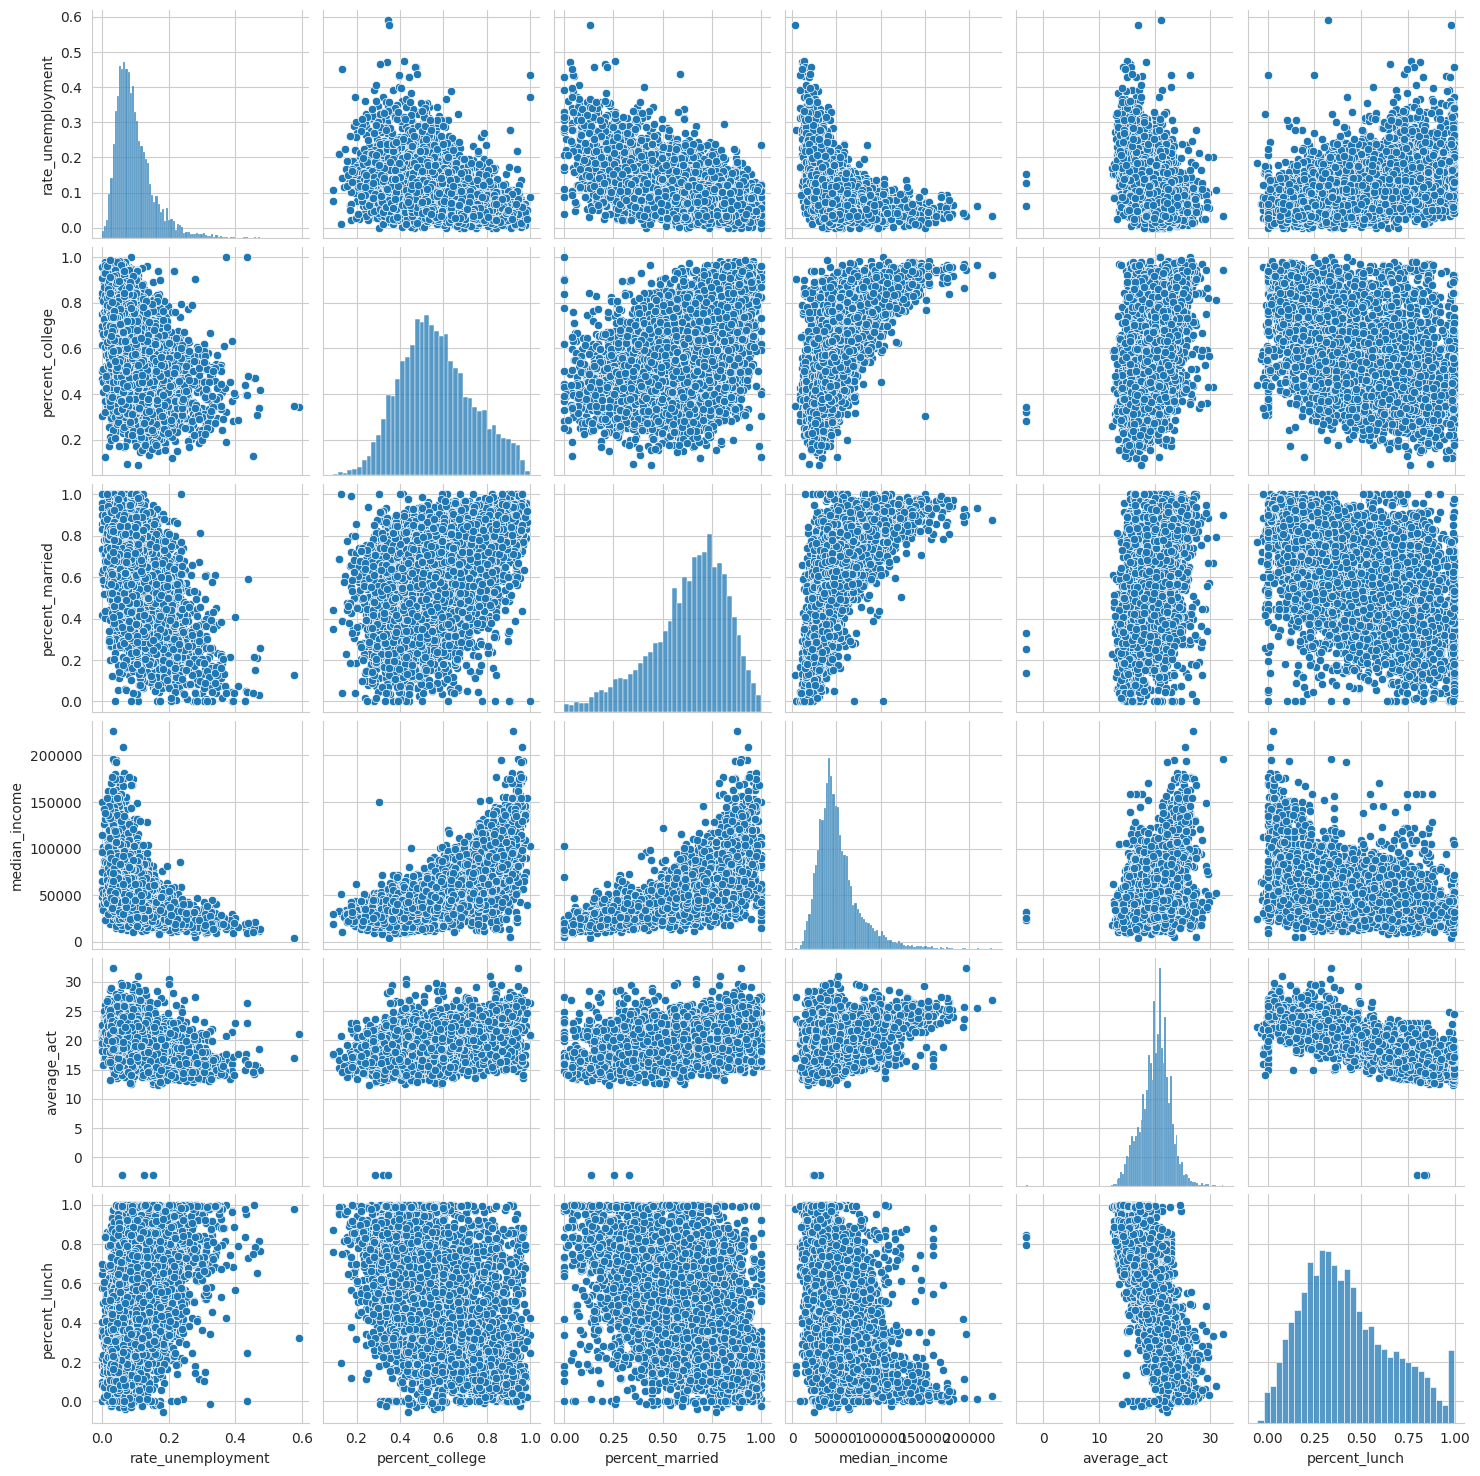

In [ ]:
plt.figure(figsize=(8, 8))
sns.pairplot(
    edgap.drop(columns="id")
);
plt.show()

From the above pair plot, we can see that average ACT scores tend to increase with higher  median income and percent of adults with a college degree, showing a positive relationship.In contrast, average ACT scores decrease as  percent of students on free lunch and unemployment rate increase, indicating a negative relationship.  
We can also notice that schools with similar socioeconomic backgrounds form visible clusters, suggesting common patterns in performance across similar communities.


2. **Adding regression lines**

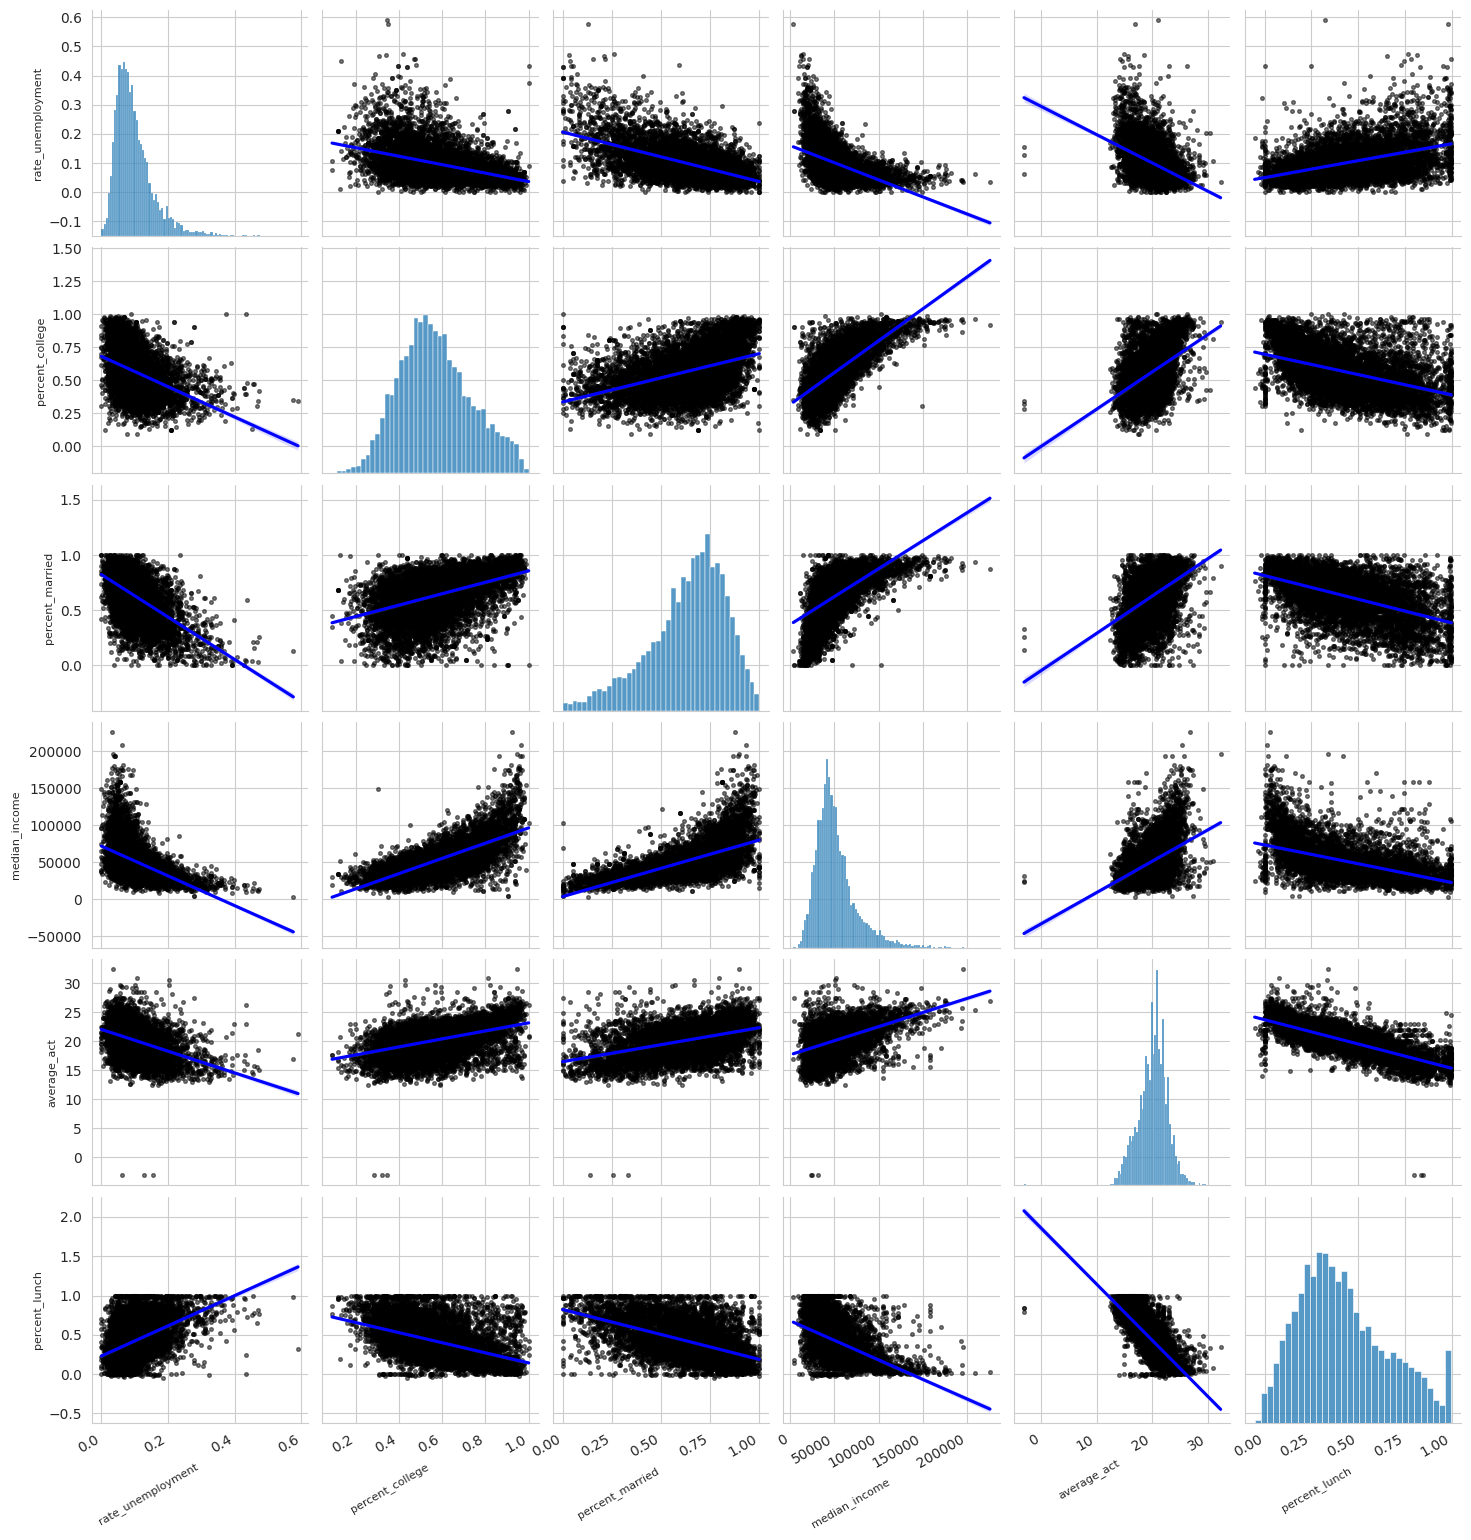

In [ ]:
# Dropping the school ID column (non-numeric)
fig = sns.pairplot(
    edgap.drop(columns="id"),
    kind="reg",  # adding regression lines
    plot_kws={
        "line_kws": {"color": "blue"},          # regression line color
        "scatter_kws": {"alpha": 0.5, "color": "k", "s": 7}  # scatter style
    }
)

# Formatting x-axis and y-axis labels
for ax in fig.axes.flat:
    if ax.get_xlabel():
        ax.set_xlabel(ax.get_xlabel(), fontsize=8, rotation=30, ha='right')
    if ax.get_ylabel():
        ax.set_ylabel(ax.get_ylabel(), fontsize=8)

# Rotate x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()

The above Regression line graph makes it easier to see whether the relationships are positive or negative and how strong they might be based on how tightly the points cluster around the line. Overall, the plot suggests that higher income and education levels are linked with higher ACT scores, while higher unemployment and lunch percentages show the opposite trend.


### Joining both the dataframes

Here we focus on combining the two primary datasets: Edgap Data (containing socioeconomic and ACT/SAT score data) and the School Info Data (providing school-level details).

We will perform a left join using the common school identifier (id) to create a single, unified dataframe named (df). This ensures that all schools from the edgap dataset are included, with matching information from the school details dataset where available. This merged dataframe will be used for the later analysis.

In [ ]:
school_information['id'] = school_information['id'].astype('object')

df = edgap.merge(
    school_information,
    how='left',
    on='id'
)

### Quality check

Before analyzing the data, we will perform a few quality checks to make sure the dataset is clean and reliable.  
This includes reviewing summary statistics, checking value ranges, handling out-of-range or invalid values, and verifying categories for school type, level, and charter.  
We should also filter the data to include only high schools (since ACT/SAT are taken by high school students) and check for any duplicates to ensure accuracy before moving forward.  

*(some of the code cells used for this inspection have been removed to keep the notebook cleaner, but these steps were performed to ensure the data was complete, consistent, and ready for analysis.)*


1. handling the out of range values

By replacing these out-of-range values with NaN, we are marking them as missing data, which allows us to handle them appropriately in subsequent data analysis steps. This helps ensure the quality and reliability of the code.

In [ ]:
# Replace out-of-range or invalid values with NaN
df.loc[df['percent_lunch'] < 0, 'percent_lunch'] = np.nan
df.loc[df['average_act'] < 1, 'average_act'] = np.nan

2. filtering the data to include only high schools

As these standardized tests are typically taken by high school students for college admissions, we will only keep the high schools data set.

In [ ]:
# Keep only the high schools in the dataset
df = df.loc[df['school_level'] == 'High']

### Handling Missing Values

In this step, we check how many missing values exist in each column and calculate their percentages. This helps identify incomplete or inconsistent data that might affect the results.
We also check which states are represented in the dataset to ensure that the data covers multiple regions across the U.S.
Finally, a map visualization is created to show where most schools are located and to identify any missing regions or data gaps.

*(some of the code cells used for this inspection have been removed to keep the notebook cleaner, but these steps were performed to ensure the data was complete, consistent, and ready for analysis)*

1. checking how many states are represented in our dataset.

In [ ]:
# Check how many schools we have per state
df['state'].value_counts()

# Check how many unique states exist
df['state'].nunique()

20

2. The average ACT score is our key response variable for this analysis.
Because we cannot analyze schools without ACT scores, we will remove rows where average_act is missing.
We will only keep other socioeconomic variables.

In [ ]:
# Drop rows where average ACT score is missing
df = df.dropna(subset=['average_act'])

### Data Imputation

(Filling the missing values)

In this step, we start by identifying the variables for imputation.
The Iterative Imputer predicts missing values based on relationships between other features, making the replacements more accurate than simple mean or median.
It repeatedly models each feature with missing values as a function of the others and fills them in accordingly.
We only use the numerical columns from the predictor list since they can be directly used for imputation.
Once this process is complete, we will have a clean dataset ready for further analysis.

In [ ]:
# Define predictor variables for imputation
predictor_variables = [
    'rate_unemployment',
    'percent_college',
    'percent_married',
    'median_income',
    'percent_lunch',
    'state',
    'charter'
]

# Select only numerical predictor columns
numerical_predictors = df[predictor_variables].select_dtypes(include='number').columns.to_list()

print(numerical_predictors)

['rate_unemployment', 'percent_college', 'percent_married', 'median_income', 'percent_lunch']


Imputer engages in learning from the data

In [ ]:
from sklearn.impute import IterativeImputer

# Learn patterns in the numeric columns
imputer.fit(df.loc[:, numerical_predictors])


IterativeImputer(random_state=0)

Let us replace missing values in the same columns.
We use the .transform( ) method to perform this replacement, effectively filling the gaps in the dataset.

In [ ]:
# Apply the imputer to fill missing values
df.loc[:, numerical_predictors] = imputer.transform(df.loc[:, numerical_predictors])

print('missing values filled!')

missing values filled!


Let us export the Clean Dataset.

In [ ]:
# Export clean dataset
df.to_csv('education_clean.csv', encoding='utf-8-sig', index=False)

# For Colab: download the CSV
from google.colab import files
files.download('education_clean.csv')
print('Clean dataset exported!')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Clean dataset exported!


###Exploratory data analysis

we start by plotting a correlation heat map to see how strongly each variable is related to one another. Next, we will use a pair plot to visualize these relationships in more detail.


1. Heat Map (uses color to show how strongly different variables are related to each other.)

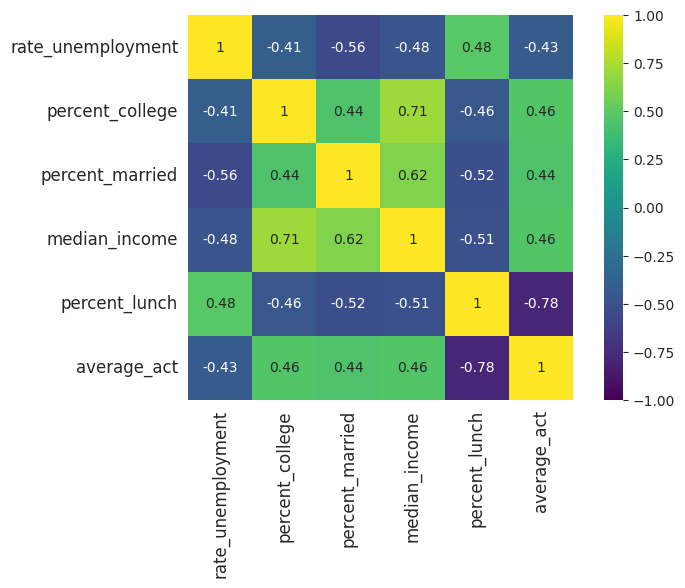

In [ ]:
predictor_variables = ['rate_unemployment', 'percent_college', 'percent_married', 'median_income', 'percent_lunch']

numerical_predictors = df[predictor_variables].select_dtypes(include='number').columns.to_list()

corr_matrix = df[numerical_predictors + ["average_act"]].corr()

plt.figure(figsize=(8, 5))

sns.heatmap(
    corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap="viridis"
)

plt.tick_params(labelsize=12)

plt.show()

From the heatmap, we can see that percent_lunch has a strong negative correlation with average_act, meaning that as the percentage of students on free or reduced lunch increases, ACT scores tend to go down.
Meanwhile, percent_college and median_income show a positive correlation with average_act, suggesting that higher income and education levels are linked to better performance.

2. Pair plots

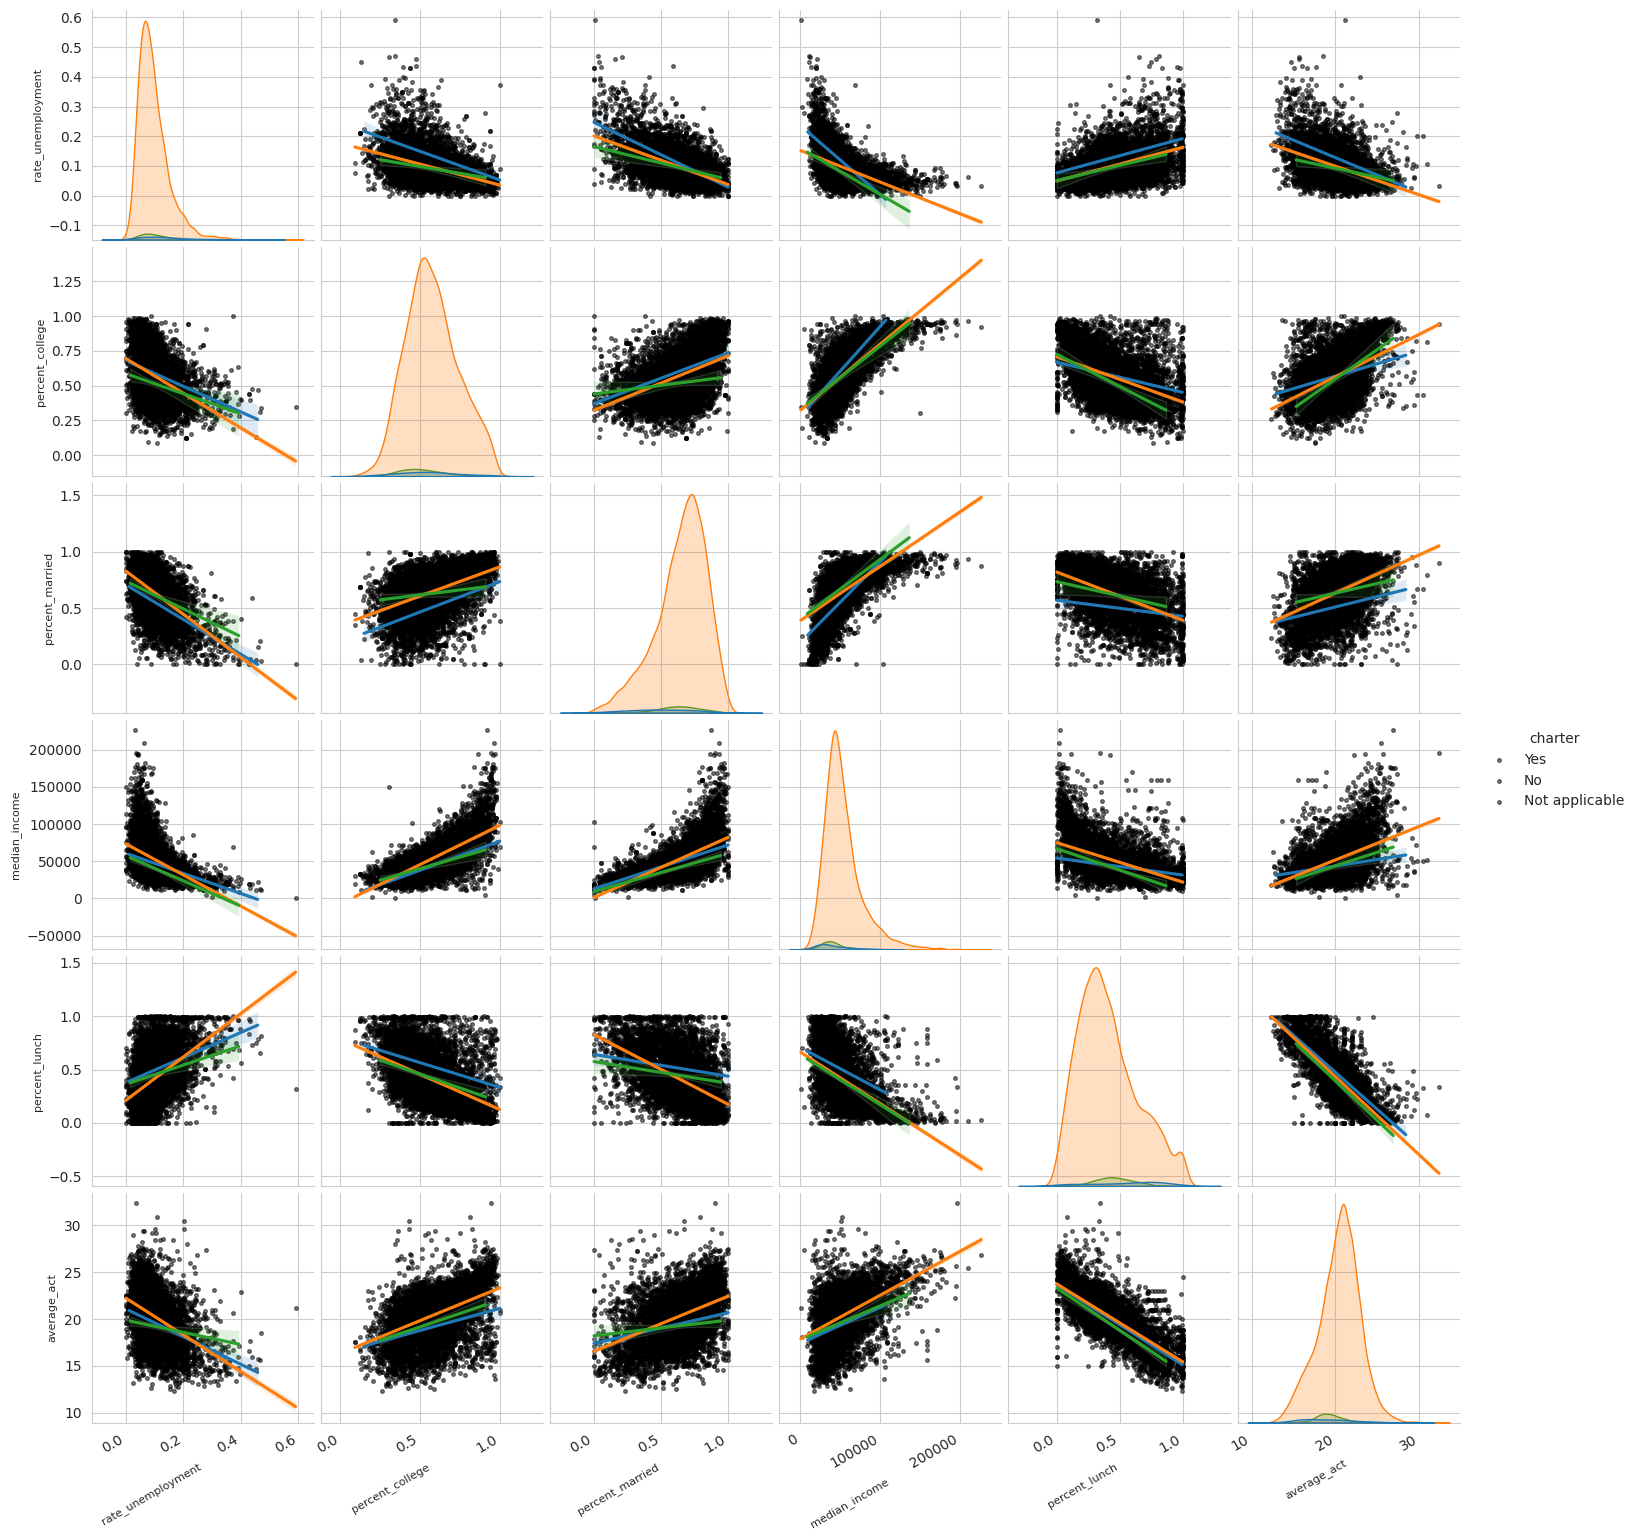

In [ ]:
fig = sns.pairplot(
    data=df,
    vars=numerical_predictors + ['average_act'],
    hue='charter',
    kind="reg",
    plot_kws={"scatter_kws": {"alpha": 0.5, "color": "k", "s": 7},
    },
)

for ax in fig.axes.flat:
    if ax.get_xlabel() == 'median income':
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))  # Apply scientific notation
    ax.set_xlabel(ax.get_xlabel(), fontsize=8, rotation=30, ha='right')  # X-axis label size and rotation
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)  # Y-axis label size

    # Rotate x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()

From the above pair plot we can say, schools with higher median household income and a greater percentage of college-educated adults tend to have higher ACT scores. Schools with a higher percentage of students on free or reduced lunch or higher unemployment rates tend to have lower ACT scores.
Most variables show consistent relationships such as socioeconomic status improves, ACT scores increase.

###Modeling

we will explore how median household income affects average ACT scores using regression models.
1. Simple Linear Regression model: helps us check if there’s a straight-line relationship between income and ACT scores.
2. Quadratic (curved) model: helps us see if the relationship changes at higher income levels.
3. Multiple Linear Regression model: includes all socioeconomic variables together to see how they jointly affect ACT scores.
4. Reduced Model: uses only the most important predictors such as unemployment rate, college percentage, and free lunch percentage to make the model simpler and more efficient.

Finally, we compare all the models using statistical tests (like ANOVA) and accuracy measures (R-squared, RMSE, MAE) to find out which model fits better.

1. Linear Regression

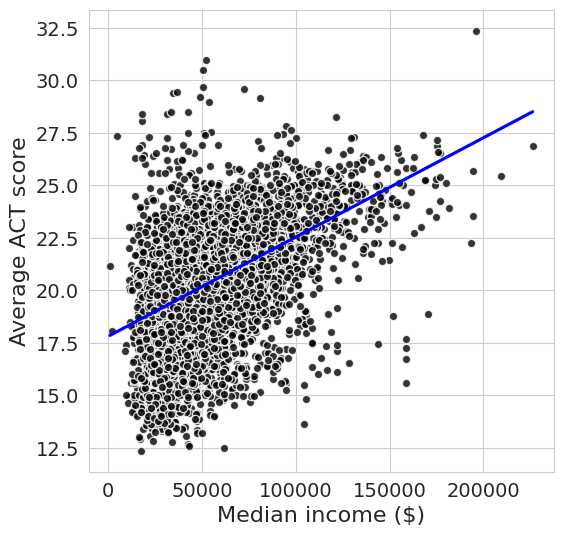

In [ ]:
plt.figure(figsize=(6, 6))

sns.regplot(data=df,
            x='median_income',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Add axis labels
plt.xlabel('Median income ($)', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

From above, we can say, as income increases, ACT scores also tend to rise.

Numercial Assessment of Fit Accuracy



In [ ]:
#Computing the R-squared value
r_squared = model_median_income.rsquared
print(f"r_squared: {r_squared:.3f}")

#Computing the RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Generate predictions using the linear model and the correctly filtered X
predictions = model_median_income.predict(X)
rmse = np.sqrt(mean_squared_error(y, predictions))
print(f"rmse: {rmse:.3f}")

#Computing the Mean Absolute Error
mae = mean_absolute_error(y, predictions)
print(f"mae: {mae:.3f}")

r_squared: 0.211
rmse: 2.228
mae: 1.713


As a part of numerical assessment of fit accuracy we found R² = 0.21, RMSE = 2.27, and MAE = 1.72.
This means our model explains about 21% of the changes in ACT scores, and the predictions are fairly close to the real values, not perfect, but good.


2. Quadratic model

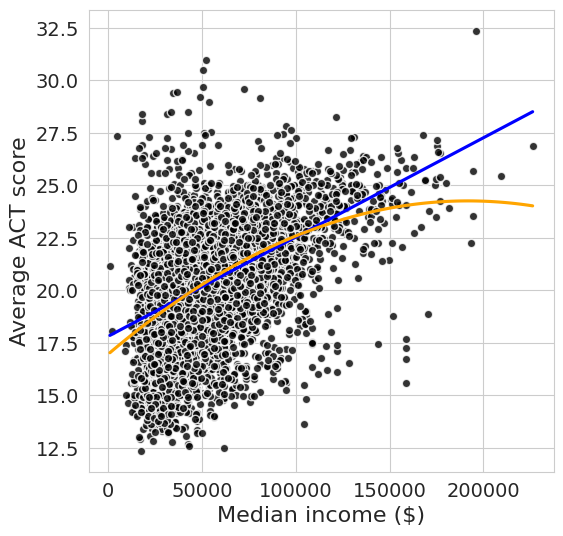

In [ ]:
plt.figure(figsize=(6, 6))

sns.regplot(data=df,
            x='median_income',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths': 1})

# Fit the quadratic model and assign it to a variable
model_median_income2 = smf.ols(
    formula='average_act ~ median_income + I(median_income**2)',
    data=df
).fit()

sns.regplot(data=df,
            x='median_income',
            y='average_act',
            order=2,
            color='orange',
            ci=False,
            scatter=False)

# Add axis labels
plt.xlabel('Median income ($)', fontsize=16)
plt.ylabel('Average ACT score', fontsize=16)

# Increase the fontsize of the tick labels
plt.tick_params(labelsize=14)

plt.show()

from above, we can say, higher median income tendS to have higher ACT scores

Numerical assessment

In [ ]:
# Compute the R-squared value
r_squared = model_median_income2.rsquared
print(f"r_squared: {r_squared:.3f}")

# Compute the Root Mean Squared Error
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_true = df['average_act']
y_pred = model_median_income2.predict(df)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"rmse: {rmse:.3f}")

# Compute the Mean Absolute Error
mae = mean_absolute_error(y_true, y_pred)
print(f"mae: {mae:.3f}")

r_squared: 0.219
rmse: 2.216
mae: 1.697


The quadratic model fits slightly better than the linear one, explaining about 22% of the changes in ACT scores.

3. Multiple Linear Regression

In [ ]:
formula = 'average_act ~ rate_unemployment + percent_college + percent_married + median_income + percent_lunch'

# Fit the multiple linear regression model
model_full = smf.ols(formula=formula, data=df).fit()

In [ ]:
# Print the R-squared value for the full multiple linear regression model
print(f"R-squared for Full Model: {model_full.rsquared:.3f}")

R-squared for Full Model: 0.628


The above R-squared value is much higher compared to the simple linear and quadratic regression models, suggesting that this multiple linear regression model provides a better fit.

###Reduced model

We will now build a reduced regression model using only the significant predictors such as the unemployment rate, college percentage, and free lunch percentage.
These predictors were chosen because they showed the strongest statistical relationships with the average ACT score in the earlier models.

In [ ]:
model_reduced = smf.ols(
    formula='average_act ~ rate_unemployment + percent_college + percent_lunch',
    data=df
).fit()


Plotting a residual plot

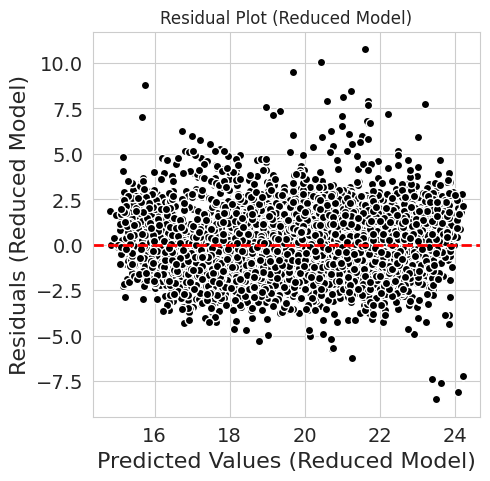

In [ ]:
plt.figure(figsize=(5,5))

# Generate predictions for the reduced model to match the residuals
y_hat_reduced = model_reduced.predict(df[predictor_variables])

plt.plot(y_hat_reduced, model_reduced.resid, 'ko', mec='w') # Use predictions from the reduced model
plt.axhline(0, color='r', linestyle='--', lw=2)

plt.xlabel('Predicted Values (Reduced Model)', fontsize=16) # Update label
plt.ylabel('Residuals (Reduced Model)',fontsize=16 ) # Update label

plt.title('Residual Plot (Reduced Model)') # Update title

plt.tick_params(labelsize=14)
plt.show()

The above residual plot shows that the errors are randomly scattered around zero with no clear pattern, indicating that the reduced model fits the data well. This confirms that the model meets linear regression assumptions and provides reliable predictions.

Let us now compare the accuracy between full and reduced models.

In [ ]:
# Generate predictions for the full model
predictions_full = model_full.predict(df) # Use model_full and provide the df DataFrame

# Generate predictions for the reduced model

# Use the predictor variables that were used to fit the reduced model
predictions_reduced = model_reduced.predict(df[predictor_variables])

# Compute MAE for both models
mae_full = mean_absolute_error(df['average_act'], predictions_full)
mae_reduced = mean_absolute_error(df['average_act'], predictions_reduced)

# Get R-squared for both models
r2_full = model_full.rsquared # Use model_full
r2_reduced = model_reduced.rsquared

# Create a DataFrame to compare metrics
comparison_df = pd.DataFrame({
    'Mean Absolute Error': [mae_full, mae_reduced],
    'R-squared': [r2_full, r2_reduced]
},
index= ['Full Model', 'Reduced Model']).round(4)

# Display the comparison DataFrame
display(comparison_df)

,Mean Absolute Error,R-squared
Full Model,1.1453,0.6280
Reduced Model,1.1455,0.6279


With only a very small difference in accuracy, the reduced multiple linear regression model using these three predictors provides a good fit to the data and is more efficient than the model that included all the initial socioeconomic variables.

In [ ]:
anova_table_reduced_full = anova_lm(model_reduced, model_full)

display(anova_table_reduced_full)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,7223.0,16916.619167,0.0,NaN,NaN,NaN
1,7221.0,16915.612457,2.0,1.006711,0.214874,0.806648


Here, the p-value is not significant, meaning there’s no strong evidence that the full model performs better than the reduced one.

This tells us that the extra variables in the full model (like percent married or median income) don’t add meaningful improvement to the prediction of ACT scores.

# Scaling

In this step, we standardized the predictor variables (unemployment rate, college percentage, and free/reduced lunch percentage) so they are on the same scale.
We transformed them to have a mean of 0 and a standard deviation of 1 using StandardScaler.
Scaling helps compare variables measured in different units (like percentages vs income) and makes model coefficients easier to interpret.

In [ ]:
scaled_columns = [var + "_normalized" for var in predictor_variables]

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler to the selected predictor variables
scaler.fit(df[predictor_variables])

StandardScaler()

In [ ]:
df[scaled_columns] = scaler.transform(df[predictor_variables])

Fit the Multiple linear regression model with the normalized predictors

In [ ]:
model_normalized = smf.ols(
    formula='average_act ~ rate_unemployment_normalized + percent_college_normalized + percent_lunch_normalized',
    data=df
).fit()

compare the accuracy between original and normalized models

In [ ]:
predictions_normalized = model_normalized.predict(df[scaled_columns])
predictions_reduced = model_reduced.predict(df[predictor_variables]) # Changed df_temp to df

# Compute MAE for both models
mae_normalized = mean_absolute_error(df['average_act'], predictions_normalized)
mae_reduced = mean_absolute_error(df['average_act'], predictions_reduced)

# Get R-squared for both models
r2_normalized = model_normalized.rsquared
r2_reduced = model_reduced.rsquared

# Create a DataFrame to compare metrics
comparison_df_normalized = pd.DataFrame({
    'Mean Absolute Error': [mae_normalized, mae_reduced],
    'R-squared': [r2_normalized, r2_reduced]
},
index= ['Normalized Model', 'Reduced (Original) Model']).round(4)

# Display the comparison DataFrame
display(comparison_df_normalized)

,Mean Absolute Error,R-squared
Normalized Model,1.1455,0.6279
Reduced (Original) Model,1.1455,0.6279


After scaling the variables, the model performed the same as before. The MAE and R-squared values barely changed, meaning scaling didn’t improve or reduce the model’s accuracy. The main benefit of scaling here is that it puts all predictors on the same scale, which makes the coefficients easier to understand, but it doesn’t change how well the model predicts ACT scores.

---



## Conclusion

In this project, we looked at how different socioeconomic factors affect average ACT/SAT scores in schools across the U.S.

Our results showed a strong connection between these factors and student performance. In particular, schools in areas with lower unemployment rates, more adults with college degrees, and fewer students receiving free or reduced-price lunch tended to have higher average ACT/SAT scores.

The reduced multiple linear regression model, which used only these three factors, explained about 62.8% of the variation in test scores (R-squared = 0.628). This model performed just as well as the full model with all the variables, showing that these three predictors are the most important ones in explaining student achievement.

Overall, this analysis suggests that students in communities with stronger economic and educational support systems perform better on standardized tests. It highlights how much socioeconomic conditions can shape educational opportunities and outcomes.

---



---

